## 資料前處理

### 1. 整理各個捷運站廁所位置

In [1]:
import pandas as pd
import numpy as np

# 讀取 csv 檔案
tpi_mrt = pd.read_csv('臺北捷運車站設施資訊.csv', encoding = 'big5')

# 只保留 '車站名稱' 和 '廁所' 兩個欄位
selected_columns = ['車站名稱','廁所']
tpi_mrt = tpi_mrt[selected_columns]

# 將 '非付費區' 改成 '非廁所'
# 避免 '非付費區' 被 '付費區' 取代
tpi_mrt['廁所2.0'] = tpi_mrt['廁所'].str.replace('非付費區', '非廁所')

# 創建可以判斷是否為付費區和非付費區的函數
# 站內有廁所：yes，站內無廁所：no
def check_paid_toilet(cell):
    return "yes" if '付費區' in cell else "no"
# 站外有廁所：yes，站外無廁所：no
def check_non_paid_toilet(cell):
    return "yes" if '非廁所' in cell else "no"

# 建立新欄位 '付費區' 和 '非付費區' 
tpi_mrt['站內'] = tpi_mrt['廁所2.0'].apply(check_paid_toilet)
tpi_mrt['站外'] = tpi_mrt['廁所2.0'].apply(check_non_paid_toilet)

# 定義新欄位 '站內外'的條件
conditions = [
    (tpi_mrt['站內'] == "yes") & (tpi_mrt['站外'] == "yes"),
    (tpi_mrt['站內'] == "no") & (tpi_mrt['站外'] == "yes"),
    (tpi_mrt['站內'] == "yes") & (tpi_mrt['站外'] == "no")
]
values = ["站內外", "站外", "站內"]
# 建立新欄位 '站內外'
tpi_mrt['站內外'] = np.select(conditions, values, default=0)

# 計算站名的字數
tpi_mrt['字數'] = tpi_mrt['車站名稱'].str.len()

# 將 '車站名稱' 加上‘站’字
tpi_mrt['車站名稱'] = tpi_mrt['車站名稱'] + '站'

# 把 '廁所' 和 '廁所2.0' 兩個欄位刪除
toilet = ['車站名稱','站內','站外','站內外','字數']
tpi_mrt = tpi_mrt[toilet]

tpi_mrt.head()

,車站名稱,站內,站外,站內外,字數
0,松山機場站,yes,yes,站內外,4
1,中山國中站,yes,no,站內,4
2,南京復興站,yes,yes,站內外,4
3,忠孝復興站,yes,no,站內,4
4,大安站,yes,no,站內,2


### 2. 車站出口數：高、中、低

In [2]:
import pandas as pd

# 讀取 CSV 檔案
file_path = '臺北捷運車站出入口座標.csv'
df = pd.read_csv('臺北捷運車站出入口座標.csv', encoding='big5')
df = df.rename(columns={'出入口名稱': 'gate_name', '出入口編號': 'exit_number'})

# 將 'exit_number' 列轉換為數字
df['exit_number'] = pd.to_numeric(df['exit_number'], errors='coerce')

# 找出每個站點的最大出口數
max_exit_per_station = df.groupby('gate_name')['exit_number'].max().reset_index()
max_exit_per_station.columns = ['gate_name', 'max_exit']

# 合併最大出口數到原始數據框
df = pd.merge(df, max_exit_per_station, on='gate_name', how='left', suffixes=('_left', '_right'))

# 將同站名的車站出口合併
df['gate_name'] = df['gate_name'].str.extract(r'(.+?站)')

# 選擇具有最大出口數的那一行
df_result = df.loc[df.groupby('gate_name')['exit_number'].idxmax().dropna()]

# 新增一列 '人流分類'，進行人流分類
df_result['人流分類'] = ''
df_result['人流分類'] = df_result['人流分類'].astype(str)  # 確保 '人流分類' 列是字符串類型

# 進行人流分類
df_result.loc[df_result['max_exit'].isin([0, 1, 2]), '人流分類'] = '低'
df_result.loc[(df_result['max_exit'] >= 3) & (df_result['max_exit'] == df_result.groupby('gate_name')['max_exit'].transform('max')), '人流分類'] = '中'
df_result.loc[df_result['max_exit'] >= 5, '人流分類'] = '高'

# 刪除不需要的暫存列
df_result = df_result.drop(['exit_number'], axis=1)

# 將結果寫入新的 CSV 檔案
df_result.to_csv('result.csv', index=False, encoding='big5')

# 將數據按索引號排序
df_result = df_result.sort_values(by='人流分類', ascending=False)

# 重新設定索引號
df_result = df_result.reset_index(drop=True)

# 選擇需要的列
select = ['gate_name', 'max_exit', '人流分類']
df_result = df_result[select]
df_result['max_exit'] = df_result['max_exit'].replace(0, 1)

df_result.head()

/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/1282356786.py:22: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df_result = df.loc[df.groupby('gate_name')['exit_number'].idxmax().dropna()]


,gate_name,max_exit,人流分類
0,忠孝敦化站,8.0,高
1,忠孝復興站,5.0,高
2,江子翠站,6.0,高
3,永春站,5.0,高
4,東門站,8.0,高


### 3. 各個站的線路顏色

In [3]:
import pandas as pd
import numpy as np

# 讀取 csv 檔案
tpi_color = pd.read_csv('11003_各線之洪水位及防洪高程資料.csv')

# 只保留 '車站名稱' 和 '廁所' 兩個欄位，去掉萬大線
selected_columns = ['線別','車站/機廠']
tpi_color = tpi_color[selected_columns]
tpi_color = tpi_color.head(139)
tpi_color

# 定義條件和對應的標籤
conditions = [
    (tpi_color['線別'] == '淡水線'),
    (tpi_color['線別'] == '信義線'),
    (tpi_color['線別'] == '新店線'),
    (tpi_color['線別'] == '松山線'),
    (tpi_color['線別'] == '文山內湖線'),
    (tpi_color['線別'] == '中和線'),
    (tpi_color['線別'] == '新莊線'),
    (tpi_color['線別'] == '蘆洲線'),
    (tpi_color['線別'] == '南港線'),
    (tpi_color['線別'] == '板橋線'),
    (tpi_color['線別'] == '土城線'),
    (tpi_color['線別'] == '環狀線第一階段')    
]
labels = ['紅', '紅', '綠', '綠', '棕', '橘', '橘', '橘', '藍', '藍', '藍', '黃']

# 新增一個欄位表示捷運線路顏色
tpi_color['顏色'] = np.select(conditions, labels, default = '')

# 新增一個欄位分出捷運站名和代號
tpi_color['車站代號'] = tpi_color['車站/機廠'].str.extract('([A-Za-z0-9]+)')
tpi_color['站名'] = tpi_color['車站/機廠'].str.extract('\(([^)]+)\)')

# 刪除重複的站名
tpi_color = tpi_color.drop_duplicates(subset='站名', keep='first')

# 轉乘站
transfer_station = ['民權西路站', '中山站', '台北車站', '中正紀念堂站', '東門站', '大安站', '南京復興站', '松江南京站', '西門站', '古亭站', '大坪林站',
                    '板橋站', '忠孝新生站', '忠孝復興站', '南港展覽館站', '景安站', '頭前庄站']
tpi_color.loc[tpi_color['站名'].isin(transfer_station), '顏色'] = '轉乘站'
tpi_color

select = ['顏色', '車站代號', '站名']
tpi_color = tpi_color[select]
tpi_color.head()

,顏色,車站代號,站名
0,紅,R09,台大醫院站
1,轉乘站,R10,台北車站
2,轉乘站,R11,中山站
3,紅,R12,雙連站
4,轉乘站,R13,民權西路站


### 4. 合併檔案
- tpi_mrt
- tpi_color
- df_result

In [4]:
data = pd.merge(tpi_mrt, tpi_color, left_on = '車站名稱', right_on = '站名', how = 'outer')
data = pd.merge(data, df_result, left_on = '車站名稱', right_on = 'gate_name', how = 'outer')
data.to_csv('data.csv', index = False, encoding = 'big5')
data.head()

,車站名稱,站內,站外,站內外,字數,顏色,車站代號,站名,gate_name,max_exit,人流分類
0,松山機場站,yes,yes,站內外,4.0,棕,BR13,松山機場站,松山機場站,3.0,中
1,中山國中站,yes,no,站內,4.0,棕,BR12,中山國中站,中山國中站,1.0,低
2,南京復興站,yes,yes,站內外,4.0,轉乘站,BR11,南京復興站,南京復興站,8.0,高
3,忠孝復興站,yes,no,站內,4.0,轉乘站,BR10,忠孝復興站,忠孝復興站,5.0,高
4,大安站,yes,no,站內,2.0,轉乘站,BR09,大安站,大安站,6.0,高


## 結果

### 讀取資料與簡單資料整理

In [ ]:
# 字體
#!gdown 1lv0-HBUhnM0rg7rOWDYWPUp93WB5xwsM -O taipei_sans_tc_beta.ttf

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

# 指定字型檔案路徑
font_path = 'taipei_sans_tc_beta.ttf'

# 設定中文字型
font_prop = FontProperties(fname = font_path)
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

# 讀取 csv 檔案
tpi = pd.read_csv('data.check2.csv', encoding = 'big5')

# 讓顏色按照順序排列，畫圖時可以按照順序
color_list = ['紅', '橘', '黃', '綠', '藍', '棕', '轉乘站']
tpi['顏色'] = pd.Categorical(tpi['顏色'], categories = color_list, ordered = True)
# 讓人流分類按照順序排列
people_list = ['高', '中', '低']
tpi['人流分類'] = pd.Categorical(tpi['人流分類'], categories = people_list, ordered = True)

tpi.head()

,車站名稱,站內,站外,站內外,字數,顏色,車站代號,max_exit,人流分類
0,松山機場站,yes,yes,站內外,4,棕,BR13,3,中
1,中山國中站,yes,no,站內,4,棕,BR12,1,低
2,南京復興站,yes,yes,站內外,4,轉乘站,BR11,8,高
3,忠孝復興站,yes,no,站內,4,轉乘站,BR10,5,高
4,大安站,yes,no,站內,2,轉乘站,BR09,6,高


In [6]:
# 設定顏色條件
color = {'紅':'crimson',
         '橘':'orange',
         '黃':'gold',
         '綠':'seagreen',
         '藍':'dodgerblue',
         '棕':'saddlebrown',
         '轉乘站':'purple'}
toilet_color = {"站內":'darkorange',
                "站外":'dodgerblue',
                "站內外":'forestgreen'}

### 1. 字數和站內外的關係

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none 

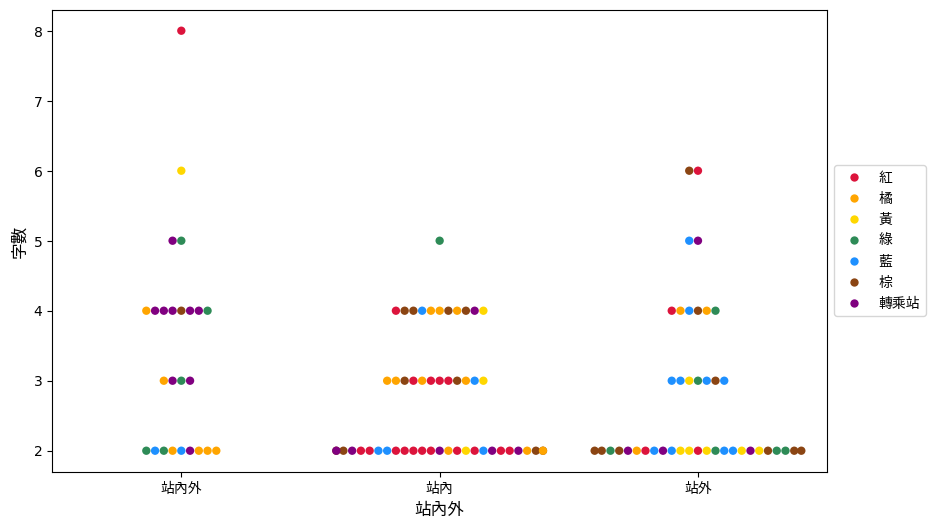

In [7]:
plt.figure(figsize = (10, 6))
plot3 = sns.swarmplot(x = tpi["站內外"], y = tpi["字數"], hue = tpi['顏色'], size = 6, palette = color)
plot3.set_xticklabels(plot3.get_xticklabels(), fontproperties = font_prop)
plot3.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = font_prop)
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found 

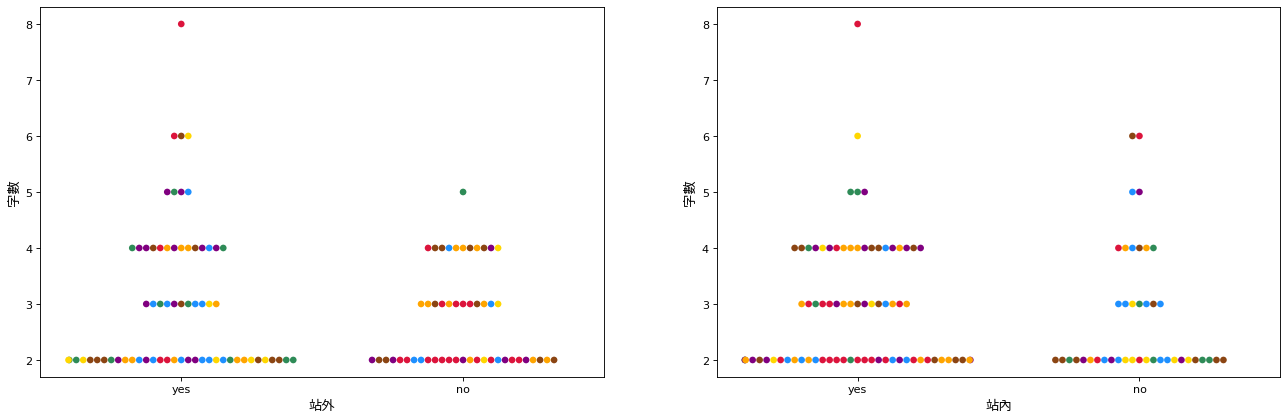

In [8]:
plt.figure(figsize = (20, 6), dpi = 80)

plt.subplot(1, 2, 1)
plot1 = sns.swarmplot(x = tpi["站外"], y = tpi["字數"], hue = tpi['顏色'], size = 6, palette = color)
plot1.legend_.remove()
plt.xlabel('站外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(1, 2, 2)
plot2 = sns.swarmplot(x = tpi["站內"], y = tpi["字數"], hue = tpi['顏色'], size = 6, palette = color)
plot2.legend_.remove()
plt.xlabel('站內', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none 

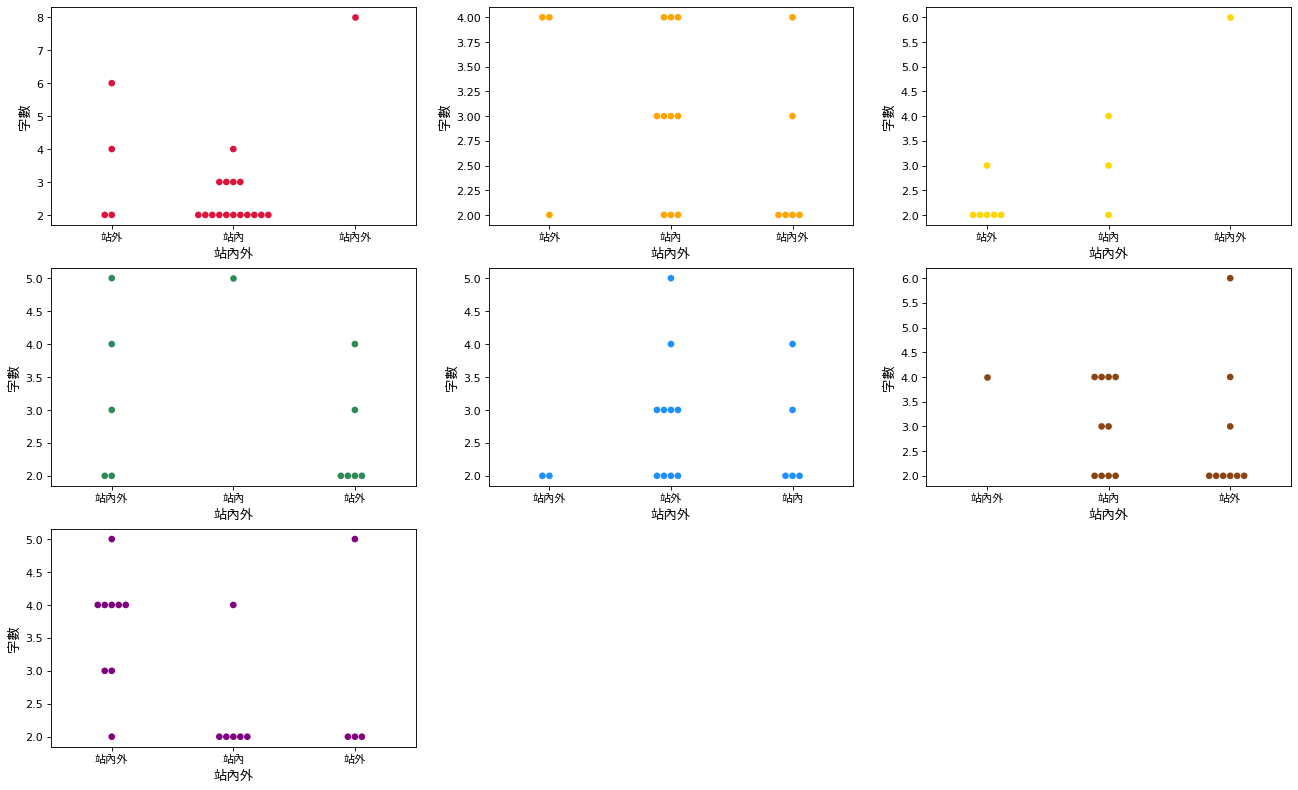

In [9]:
red = tpi[tpi['顏色'] == '紅']
orange = tpi[tpi['顏色'] == '橘']
yellow = tpi[tpi['顏色'] == '黃']
green = tpi[tpi['顏色'] == '綠']
blue = tpi[tpi['顏色'] == '藍']
brown = tpi[tpi['顏色'] == '棕']
transfers = tpi[tpi['顏色'] == '轉乘站']

plt.figure(figsize = (20, 12), dpi = 80)
plt.subplot(3, 3, 1)
plot1 = sns.swarmplot(x = red["站內外"], y = red["字數"], hue = red['顏色'], size = 6, palette = color)
plot1.set_xticklabels(plot1.get_xticklabels(), fontproperties = font_prop)
plot1.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 2)
plot2 = sns.swarmplot(x = orange["站內外"], y = orange["字數"], hue = orange['顏色'], size = 6, palette = color)
plot2.set_xticklabels(plot2.get_xticklabels(), fontproperties = font_prop)
plot2.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 3)
plot3 = sns.swarmplot(x = yellow["站內外"], y = yellow["字數"], hue = yellow['顏色'], size = 6, palette = color)
plot3.set_xticklabels(plot3.get_xticklabels(), fontproperties = font_prop)
plot3.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 4)
plot4 = sns.swarmplot(x = green["站內外"], y = green["字數"], hue = green['顏色'], size = 6, palette = color)
plot4.set_xticklabels(plot4.get_xticklabels(), fontproperties = font_prop)
plot4.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 5)
plot5 = sns.swarmplot(x = blue["站內外"], y = blue["字數"], hue = blue['顏色'], size = 6, palette = color)
plot5.set_xticklabels(plot5.get_xticklabels(), fontproperties = font_prop)
plot5.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 6)
plot6 = sns.swarmplot(x = brown["站內外"], y = brown["字數"], hue = brown['顏色'], size = 6, palette = color)
plot6.set_xticklabels(plot6.get_xticklabels(), fontproperties = font_prop)
plot6.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 7)
plot7 = sns.swarmplot(x = transfers["站內外"], y = transfers["字數"], hue = transfers['顏色'], size = 6, palette = color)
plot7.set_xticklabels(plot7.get_xticklabels(), fontproperties = font_prop)
plot7.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('字數', fontsize = 12, fontproperties = font_prop)

plt.show()

- 去掉站名字數>=5的捷運站，只剩下站名字數四個字以下的車站進行後續分析

In [10]:
tpi2 = tpi[tpi['字數'] < 5]
tpi2

,車站名稱,站內,站外,站內外,字數,顏色,車站代號,max_exit,人流分類
0,松山機場站,yes,yes,站內外,4,棕,BR13,3,中
1,中山國中站,yes,no,站內,4,棕,BR12,1,低
2,南京復興站,yes,yes,站內外,4,轉乘站,BR11,8,高
3,忠孝復興站,yes,no,站內,4,轉乘站,BR10,5,高
4,大安站,yes,no,站內,2,轉乘站,BR09,6,高
...,...,...,...,...,...,...,...,...,...
112,橋和站,no,yes,站外,2,黃,Y13,1,低
113,中原站,no,yes,站外,2,黃,Y14,1,低
114,板新站,no,yes,站外,2,黃,Y15,1,低
115,新埔民生站,yes,no,站內,4,黃,Y17,1,低


### 2. 不同顏色路線廁所在站內、站外、站內外的站數與機率
- 站內：廁所只出現在站內
- 站外：廁所只出現在站外的機率
- 站內外：站內外都有廁所的機率

/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/3508615781.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(plot.get_xticklabels(), fontproperties = font_prop)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
f

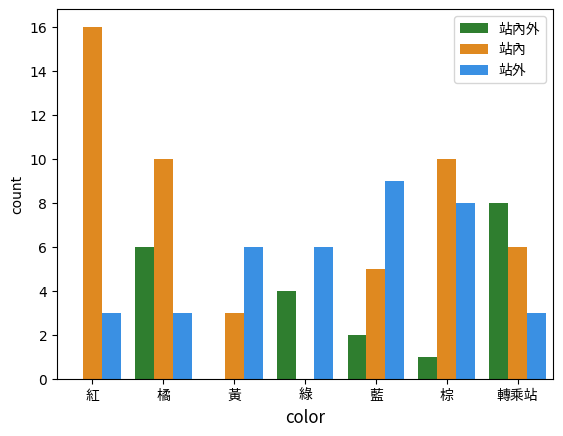

In [11]:
plot = sns.countplot(x = "顏色", hue = "站內外", data = tpi2, palette = toilet_color)
plot.set_xticklabels(plot.get_xticklabels(), fontproperties = font_prop)

plt.legend(loc = 'upper right', prop = font_prop)
plt.xlabel('color', fontsize = 12, fontproperties = font_prop)
plt.show()

In [12]:
toilet_counts = tpi2.groupby('顏色')['站內外'].value_counts(normalize=True).unstack()
toilet_onlyin_prob = toilet_counts.get('站內', 0)
toilet_onlyout_prob = toilet_counts.get('站外', 0)
toilet_inout_prob = toilet_counts.get('站內外', 0)

print("只有站內廁所機率：", toilet_onlyin_prob)
print("==========================")
print("只有站外廁所機率：", toilet_onlyout_prob)
print("==========================")
print("站內外都有廁所機率：", toilet_inout_prob)


只有站內廁所機率： 顏色
紅      0.842105
橘      0.526316
黃      0.333333
綠      0.000000
藍      0.312500
棕      0.526316
轉乘站    0.352941
Name: 站內, dtype: float64
只有站外廁所機率： 顏色
紅      0.157895
橘      0.157895
黃      0.666667
綠      0.600000
藍      0.562500
棕      0.421053
轉乘站    0.176471
Name: 站外, dtype: float64
站內外都有廁所機率： 顏色
紅      0.000000
橘      0.315789
黃      0.000000
綠      0.400000
藍      0.125000
棕      0.052632
轉乘站    0.470588
Name: 站內外, dtype: float64


/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/2027021309.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toilet_counts = tpi2.groupby('顏色')['站內外'].value_counts(normalize=True).unstack()


### 3. 不同顏色線捷運站，廁所會出現在站內或站外的機率
- 站外有廁所的機率
- 站內有廁所的機率

In [13]:
toilet_in = tpi2.groupby('顏色')['站內'].value_counts(normalize=True).unstack()
toilet_in_prob = toilet_in.get('yes', 0)
toilet_out = tpi2.groupby('顏色')['站外'].value_counts(normalize=True).unstack()
toilet_out_prob = toilet_out.get('yes', 0)

print("站內有廁所機率：", toilet_in_prob)
print("========================")
print("站外有廁所機率：", toilet_out_prob)

站內有廁所機率： 顏色
紅      0.842105
橘      0.842105
黃      0.333333
綠      0.400000
藍      0.437500
棕      0.578947
轉乘站    0.823529
Name: yes, dtype: float64
站外有廁所機率： 顏色
紅      0.157895
橘      0.473684
黃      0.666667
綠      1.000000
藍      0.687500
棕      0.473684
轉乘站    0.647059
Name: yes, dtype: float64


/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/3525120733.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toilet_in = tpi2.groupby('顏色')['站內'].value_counts(normalize=True).unstack()
/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/3525120733.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  toilet_out = tpi2.groupby('顏色')['站外'].value_counts(normalize=True).unstack()


/var/folders/k3/6dth_q6910q7zjbh7s4y2m6m0000gn/T/ipykernel_37021/114136484.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(color_list, fontproperties = font_prop)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found 

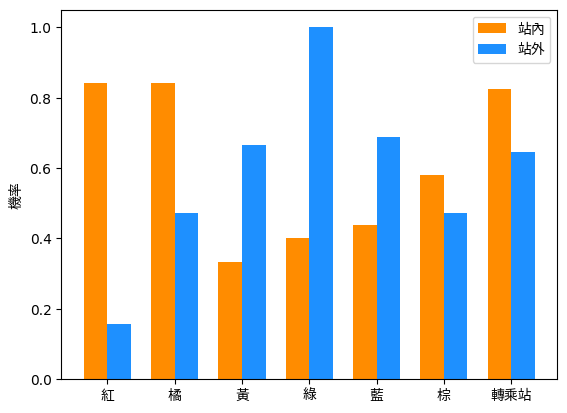

In [14]:
import numpy as np
color_list = ['0', '紅', '橘', '黃', '綠', '藍', '棕', '轉乘站']

ind = np.arange(len(toilet_in_prob))  # the x locations for the groups
width = 0.35                          # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, toilet_in_prob, width, label = '站內', color = 'darkorange')
rects2 = ax.bar(ind + width/2, toilet_out_prob, width, label = '站外', color = 'dodgerblue')

ax.set_xticklabels(color_list, fontproperties = font_prop)
ax.set_ylabel('機率', fontproperties = font_prop)
ax.legend(prop=font_prop)


### 4. 出口數和廁所在站內或站外的關係

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none 

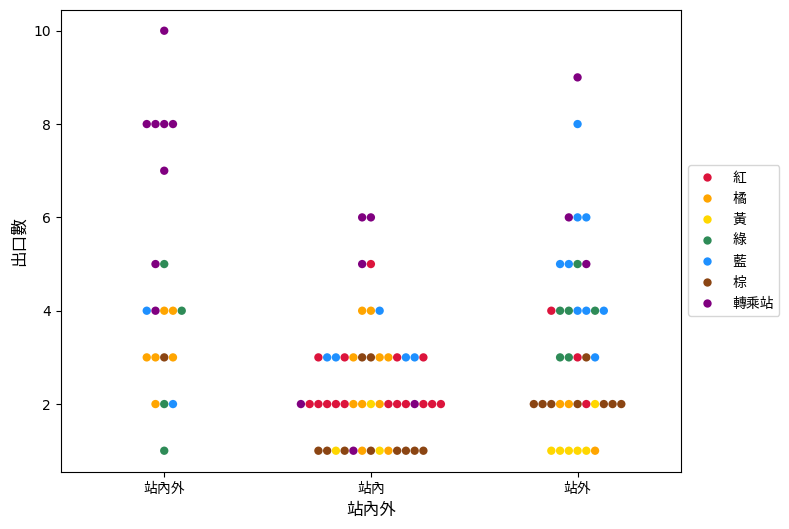

In [15]:
plt.figure(figsize = (8, 6))
plot3 = sns.swarmplot(x = tpi2["站內外"], y = tpi2["max_exit"], hue = tpi2['顏色'], size = 6, palette = color)
plot3.set_xticklabels(plot3.get_xticklabels(), fontproperties = font_prop)
plot3.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = font_prop)
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found 

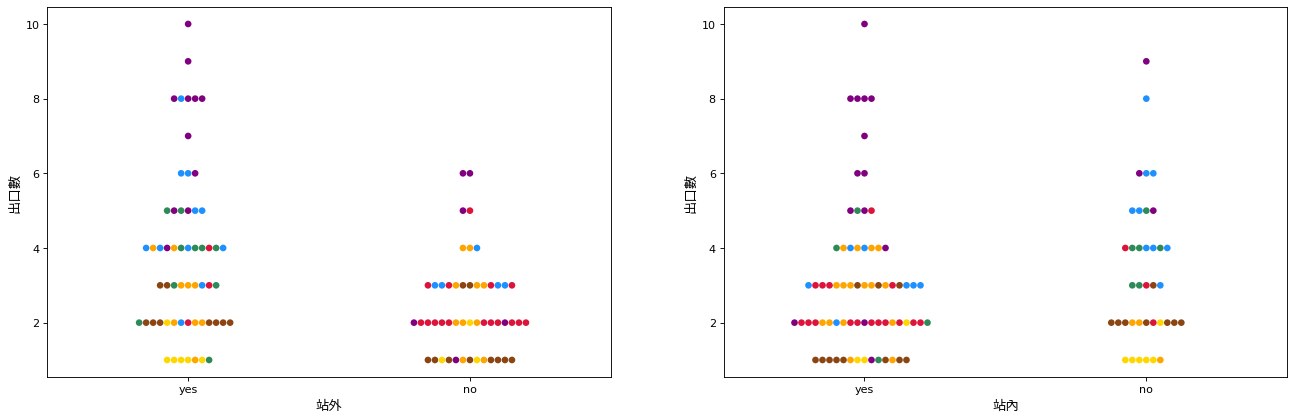

In [16]:
plt.figure(figsize = (20, 6), dpi = 80)

plt.subplot(1, 2, 1)
plot1 = sns.swarmplot(x = tpi2["站外"], y = tpi2["max_exit"], hue = tpi2['顏色'], size = 6, palette = color)
plot1.legend_.remove()
plt.xlabel('站外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(1, 2, 2)
plot2 = sns.swarmplot(x = tpi2["站內"], y = tpi2["max_exit"], hue = tpi2['顏色'], size = 6, palette = color)
plot2.legend_.remove()
plt.xlabel('站內', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.show()

- 不同顏色線路的廁所位置分佈

findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 31449 (\N{CJK UNIFIED IDEOGRAPH-7AD9}) missing from current font.
  fig.canvas.draw()
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 22806 (\N{CJK UNIFIED IDEOGRAPH-5916}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Taipei Sans TC Beta
/Users/catfish/.pyenv/versions/3.10.11/lib/python3.10/site-packages/seaborn/utils.py:84: UserWarning: Glyph 20839 (\N{CJK UNIFIED IDEOGRAPH-5167}) missing from current font.
  fig.canvas.draw()
findfont: Generic family 'sans-serif' not found because none 

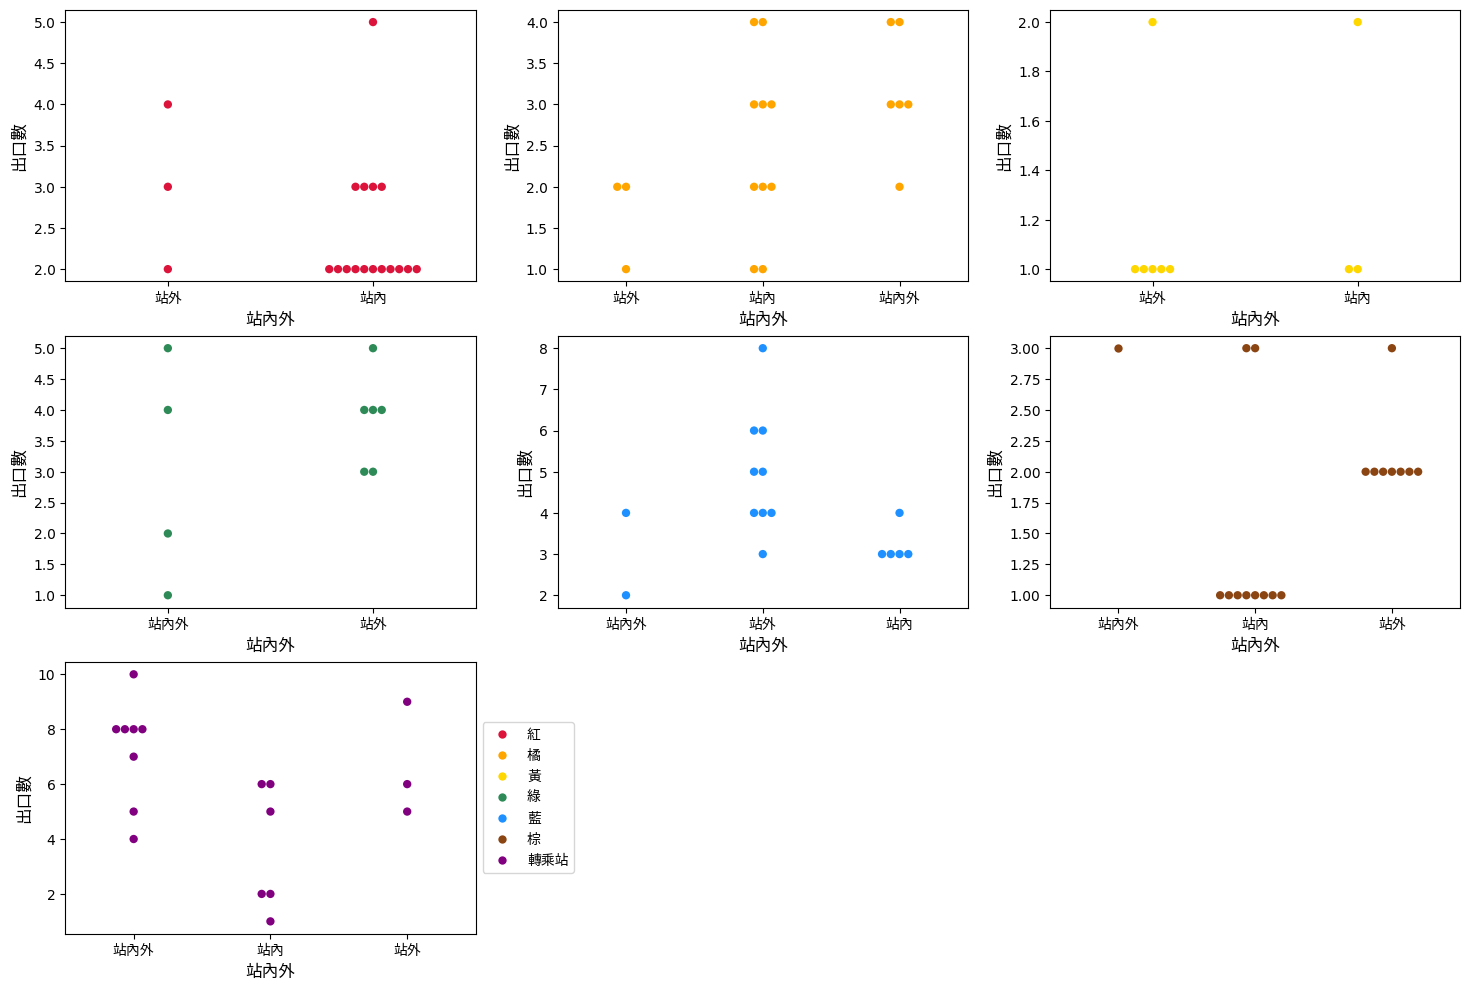

In [17]:
red = tpi2[tpi2['顏色'] == '紅']
orange = tpi2[tpi2['顏色'] == '橘']
yellow = tpi2[tpi2['顏色'] == '黃']
green = tpi2[tpi2['顏色'] == '綠']
blue = tpi2[tpi2['顏色'] == '藍']
brown = tpi2[tpi2['顏色'] == '棕']
transfers = tpi2[tpi2['顏色'] == '轉乘站']

plt.figure(figsize = (18, 12))
plt.subplot(3, 3, 1)
plot1 = sns.swarmplot(x = red["站內外"], y = red["max_exit"], hue = red['顏色'], size = 6, palette = color)
plot1.set_xticklabels(plot1.get_xticklabels(), fontproperties = font_prop)
plot1.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 2)
plot2 = sns.swarmplot(x = orange["站內外"], y = orange["max_exit"], hue = orange['顏色'], size = 6, palette = color)
plot2.set_xticklabels(plot2.get_xticklabels(), fontproperties = font_prop)
plot2.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 3)
plot3 = sns.swarmplot(x = yellow["站內外"], y = yellow["max_exit"], hue = yellow['顏色'], size = 6, palette = color)
plot3.set_xticklabels(plot3.get_xticklabels(), fontproperties = font_prop)
plot3.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 4)
plot4 = sns.swarmplot(x = green["站內外"], y = green["max_exit"], hue = green['顏色'], size = 6, palette = color)
plot4.set_xticklabels(plot4.get_xticklabels(), fontproperties = font_prop)
plot4.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 5)
plot5 = sns.swarmplot(x = blue["站內外"], y = blue["max_exit"], hue = blue['顏色'], size = 6, palette = color)
plot5.set_xticklabels(plot5.get_xticklabels(), fontproperties = font_prop)
plot5.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 6)
plot6 = sns.swarmplot(x = brown["站內外"], y = brown["max_exit"], hue = brown['顏色'], size = 6, palette = color)
plot6.set_xticklabels(plot6.get_xticklabels(), fontproperties = font_prop)
plot6.legend_.remove()
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.subplot(3, 3, 7)
plot7 = sns.swarmplot(x = transfers["站內外"], y = transfers["max_exit"], hue = transfers['顏色'], size = 6, palette = color)
plot7.set_xticklabels(plot7.get_xticklabels(), fontproperties = font_prop)
plot7.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop = font_prop)
plt.xlabel('站內外', fontsize = 12, fontproperties = font_prop)
plt.ylabel('出口數', fontsize = 12, fontproperties = font_prop)

plt.show()

### 5. 出口數、字數和廁所站內外分佈的相關性

In [19]:
mapping = {'站內外': 3, '站外': 2, '站內': 1}
tpi['站內外廁所'] = tpi['站內外'].map(mapping)

mapping2 = {'yes': 1, 'no': 0}
tpi['站內廁所'] = tpi['站內'].map(mapping2)
tpi['站外廁所'] = tpi['站外'].map(mapping2)
tpi.head()

,車站名稱,站內,站外,站內外,字數,顏色,車站代號,max_exit,人流分類,站內外廁所,站內廁所,站外廁所
0,松山機場站,yes,yes,站內外,4,棕,BR13,3,中,3,1,1
1,中山國中站,yes,no,站內,4,棕,BR12,1,低,1,1,0
2,南京復興站,yes,yes,站內外,4,轉乘站,BR11,8,高,3,1,1
3,忠孝復興站,yes,no,站內,4,轉乘站,BR10,5,高,1,1,0
4,大安站,yes,no,站內,2,轉乘站,BR09,6,高,1,1,0


In [31]:
#pip install scipy
from scipy.stats import spearmanr

correlation = tpi['max_exit'].corr(tpi['站內外廁所'], method='spearman')
print("出口數和廁所站外的相關性：",correlation)

correlation = tpi['字數'].corr(tpi['站內外廁所'], method='spearman')
print("字數和廁所站內外的相關性：",correlation)

brown = tpi[tpi['顏色'] == '棕']
correlation = brown['max_exit'].corr(brown['站內外廁所'], method='spearman')
print("棕線出口數和廁所站內外的相關性：",correlation)

transfers = tpi[tpi['顏色'] == '轉乘站']
correlation = transfers['max_exit'].corr(transfers['站內外廁所'], method='spearman')
print("轉乘站出口數和廁所站內外的相關性：",correlation)

tpi3 = tpi[tpi['字數'] >= 5]
correlation = tpi3['字數'].corr(tpi3['站外廁所'], method='spearman')
print("字數五字以上的車站和廁所站內外的相關性：",correlation)


棕線出口數和廁所站內外的相關性： 0.6270527162723902
轉乘站出口數和廁所站內外的相關性： 0.5988956007450603
出口數和廁所站外的相關性： 0.39758541261065367
字數和廁所站內外的相關性： 0.1475119903130323
字數五字以上的車站和廁所站內外的相關性： 0.3061862178478973


- 出口數和字數與廁所位置皆呈低度正相關  
- 棕線和轉乘站的出口數和廁所位置成正相關